<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/1_Bidirectional_LSTM_Multivariate_Horizon_Style_Flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [60]:
#df = pd.read_csv(r'merge-csv.com__602f0aa73c265.csv')
#df = pd.read_csv('merge-csv.com__602f0aa73c265.csv',index_col='Processing_time',
 #               infer_datetime_format=True)
#url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/Network-Flows.csv'
url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows.csv'

df = pd.read_csv(url,index_col='Processing_time',
                infer_datetime_format=True)



#df = pd.read_csv(url,index_col='Processing_time',
#               # infer_datetime_format=True)
#                parse_dates=True)

In [61]:
df.head()

,Measurement_boxname,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
Processing_time,,,,,,,,,,,,,,,
2020-12-01T00:05:24.998+09:00,smartx-microbox-gist-1,39846,9092,6,183,2438,2439,2439,0.07,161,11888,2788.26,2591.23,510252,170.018
2020-12-01T00:10:44.861+09:00,smartx-microbox-gist-1,39846,9092,6,396,2438,2439,2439,0.11,63,11856,2228.37,2094.46,882435,290.016
2020-12-01T00:15:33.979+09:00,smartx-microbox-gist-1,39846,9092,6,395,2438,2439,2439,0.13,102,13084,2209.62,2321.09,872801,290.017
2020-12-01T00:25:41.464+09:00,smartx-microbox-gist-1,39846,9092,6,459,2438,2439,2439,0.09,61,11550,1989.66,1919.81,913254,290.017
2020-12-01T00:35:18.114+09:00,smartx-microbox-gist-1,39846,9092,6,456,2438,2439,2439,0.09,87,11544,1981.21,1909.48,903430,290.011


In [62]:
df.describe()

,src_host_port,dest_host_port,protocol,protocol_count,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes,flow_duration
count,8576.000000,8576.0,8576.0,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000,8576.000000
mean,40807.862873,9092.0,6.0,362.090602,2315.889576,2317.284632,2316.846782,0.317004,76.953708,10271.796525,2104.136580,2048.747845,761531.681087,279.171818
std,3907.567979,0.0,0.0,56.159077,395.897535,394.644232,395.614646,1.226467,19.597907,1867.873236,175.951136,231.740512,131589.840309,34.988489
min,33560.000000,9092.0,6.0,22.000000,499.000000,501.000000,501.000000,0.000000,59.000000,5971.000000,1387.150000,1291.840000,44072.000000,10.014000
25%,39846.000000,9092.0,6.0,340.000000,2438.000000,2439.000000,2439.000000,0.000000,62.000000,8740.000000,1973.480000,1867.347500,686703.750000,290.015000
50%,39846.000000,9092.0,6.0,369.000000,2438.000000,2439.000000,2439.000000,0.050000,69.000000,10587.000000,2094.890000,2032.635000,709585.000000,290.016000
75%,40442.000000,9092.0,6.0,398.000000,2439.000000,2439.000000,2439.000000,0.100000,88.000000,11718.000000,2226.530000,2229.402500,882164.750000,290.017000
max,59584.000000,9092.0,6.0,514.000000,2439.000000,2439.000000,2439.000000,21.950000,264.000000,14764.000000,2899.900000,2856.150000,923288.000000,290.056000


In [63]:
#df.drop_duplicates(subset=['Processing_time'], keep=False,inplace=True)

In [64]:
Measurement_boxname_le = preprocessing.LabelEncoder()
df['Measurement_boxname_le'] = Measurement_boxname_le.fit_transform(df['Measurement_boxname']) 

In [65]:
df = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']]

In [66]:
validate = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(50)
df.drop(df.tail(50).index,inplace=True)

In [67]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [68]:
validate = df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes', 'Measurement_boxname_le']].tail(30)
df.drop(df.tail(30).index,inplace=True)

In [69]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']])
dataY = y_scaler.fit_transform(df[['total_data_bytes']])

In [70]:
"""
#hist_window = 48
#horizon = 10
hist_window =35
#horizon = 30
horizon = 10
"""
hist_window =100
horizon = 30


TRAIN_SPLIT = 5500
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [71]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.00318907 1.         1.         ... 0.92620063 0.83064738 0.53022238]
 [0.00501139 1.         1.         ... 0.5560866  0.51308245 0.95353474]
 [0.00592255 1.         1.         ... 0.54369195 0.65795782 0.94257725]
 ...
 [0.00318907 1.         1.         ... 0.61981821 0.69114817 0.95200497]
 [0.00364465 1.         1.         ... 0.46506693 0.51369613 0.95334139]
 [0.00273349 1.         1.         ... 0.44040985 0.45972346 0.55709518]]

 Target horizon
[[0.95675579]
 [0.95342669]
 [0.96434892]
 [0.93700524]
 [0.95319011]
 [0.97162017]
 [0.96217198]
 [0.95016128]
 [0.9435008 ]
 [0.5483135 ]
 [0.95733813]
 [0.96416353]
 [0.94840972]
 [0.95597214]
 [0.94372373]
 [0.94332451]
 [0.94130339]
 [0.93501483]
 [0.95018971]
 [0.9423566 ]
 [0.96352546]
 [0.54706807]
 [0.95907149]
 [0.94840176]
 [0.94293666]
 [0.96204914]
 [0.96224591]
 [0.9554262 ]
 [0.94530809]
 [0.94497712]]


In [72]:
BATCH_SIZE = 256
BUFFER_SIZE = 150
#BATCH_SIZE = 64
#BUFFER_SIZE = 37
#BATCH_SIZE = 150
#BATCH_SIZE = 64
#BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [73]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                               input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')


In [74]:
model_path = r'Bidirectional_LSTM_Multivariate.h5'

In [75]:
#EVALUATION_INTERVAL = 100
#EPOCHS = 150
#EVALUATION_INTERVAL = 70
EVALUATION_INTERVAL = 100
#EPOCHS = 150
EPOCHS = 150
#history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=30, verbose=1,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/150
100/100 [==============================] - 11s 62ms/step - loss: 0.3613 - val_loss: 0.0396
Epoch 2/150
100/100 [==============================] - 5s 47ms/step - loss: 0.0853 - val_loss: 0.0148
Epoch 3/150
100/100 [==============================] - 5s 47ms/step - loss: 0.0646 - val_loss: 0.0441
Epoch 4/150
100/100 [==============================] - 5s 47ms/step - loss: 0.0527 - val_loss: 0.0367
Epoch 5/150
100/100 [==============================] - 5s 48ms/step - loss: 0.0444 - val_loss: 0.0108
Epoch 6/150
100/100 [==============================] - 5s 48ms/step - loss: 0.0331 - val_loss: 0.0112
Epoch 7/150
100/100 [==============================] - 5s 49ms/step - loss: 0.0313 - val_loss: 0.0101
Epoch 8/150
100/100 [==============================] - 5s 48ms/step - loss: 0.0278 - val_loss: 0.0113
Epoch 9/150
100/100 [==============================] - 5s 49ms/step - loss: 0.0270 - val_loss: 0.0106
Epoch 10/150
100/100 [==============================] - 5s 49ms/step - loss: 0.02

In [76]:
Trained_model = tf.keras.models.load_model(model_path)

In [77]:
# Show the model architecture
Trained_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 100, 300)          195600    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630       
Total params: 338,650
Trainable params: 338,650
Non-trainable params: 0
_________________________________________________________________


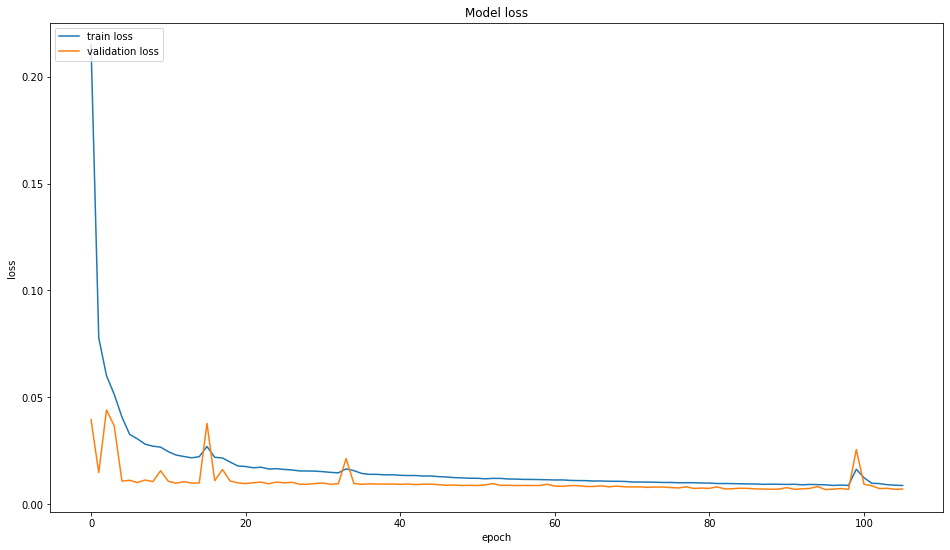

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [79]:
data_val = x_scaler.fit_transform(df[['std_dev_tcp_window_size','max_tcp_window_size','max_tcp_window_size','min_tcp_window_size','Measurement_boxname_le','min_data_bytes', 'max_data_bytes', 'avg_databytes','std_dev_databytes','total_data_bytes']].tail(100))

In [80]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [81]:
Predicted_results = Trained_model.predict(val_rescaled)

In [82]:
Predicted_results

array([[0.7383928 , 0.7173379 , 0.62781864, 0.5158395 , 0.75603986,
        0.7453337 , 0.73693675, 0.73828745, 0.7461825 , 0.71506506,
        0.7117841 , 0.7385892 , 0.72513497, 0.6976894 , 0.6368315 ,
        0.5482247 , 0.75788885, 0.74389184, 0.7363956 , 0.7363694 ,
        0.7373991 , 0.71346945, 0.71334016, 0.7299161 , 0.71062326,
        0.6911533 , 0.6484482 , 0.5746079 , 0.7554085 , 0.7425671 ]],
      dtype=float32)

In [83]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [84]:
Predicted_results_Inv_trans

array([[693278.75, 674767.  , 596060.2 , 497606.38, 708794.4 , 699381.3 ,
        691998.6 , 693186.1 , 700127.6 , 672768.7 , 669884.  , 693451.5 ,
        681622.3 , 657491.7 , 603984.5 , 526079.94, 710420.  , 698113.6 ,
        691522.8 , 691499.75, 692405.1 , 671365.75, 671252.1 , 685825.94,
        668863.4 , 651745.06, 614198.06, 549276.5 , 708239.25, 696948.94]],
      dtype=float32)

In [85]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [86]:
timeseries_evaluation_metrics_func(validate['total_data_bytes'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 18961091036.59987
MAE is : 117527.33125
RMSE is : 137699.2775456715
MAPE is : 17.749041021745825
R2 is : -1.2176124955463279



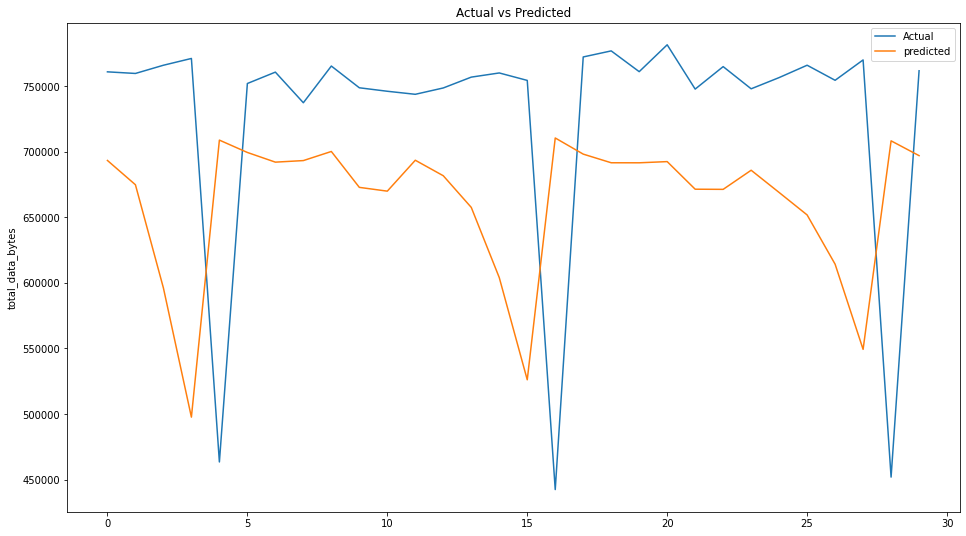

In [87]:
plt.plot( list(validate['total_data_bytes']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("total_data_bytes")
plt.legend(('Actual','predicted'))
plt.show()